In [1]:
# Import fastai, but only for the DataBlock part.
from fastai.vision.all import *

path = untar_data(URLs.MNIST)

# Create a subset of the images, so we train faster. We do this by taking 500 random images of each digit.
set_seed(0)
num_imgs_per_digit = 500
items = [
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit]
]

# Create the `dataloaders`. We need a slightly special `ImageBlock` because we want grayscale images.

block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")


5000 training images, 5000 validation images


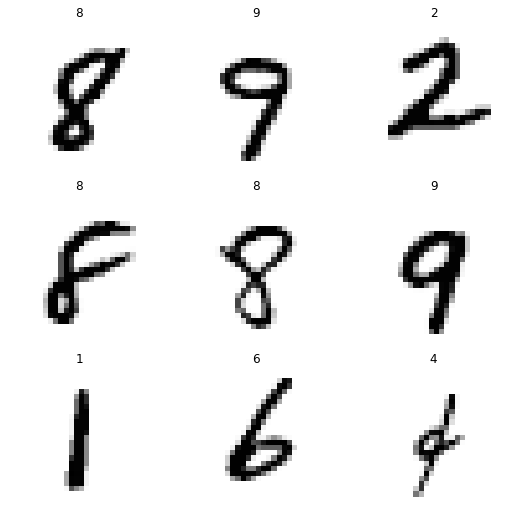

In [2]:
dataloaders.train.show_batch()

In [3]:
print(f"Available categories: {dataloaders.train.vocab}")

Available categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
images, labels = dataloaders.train.one_batch()
images = cast(images, Tensor) # work around a fastai quirk
labels = cast(labels, Tensor)
images.shape

torch.Size([16, 1, 28, 28])

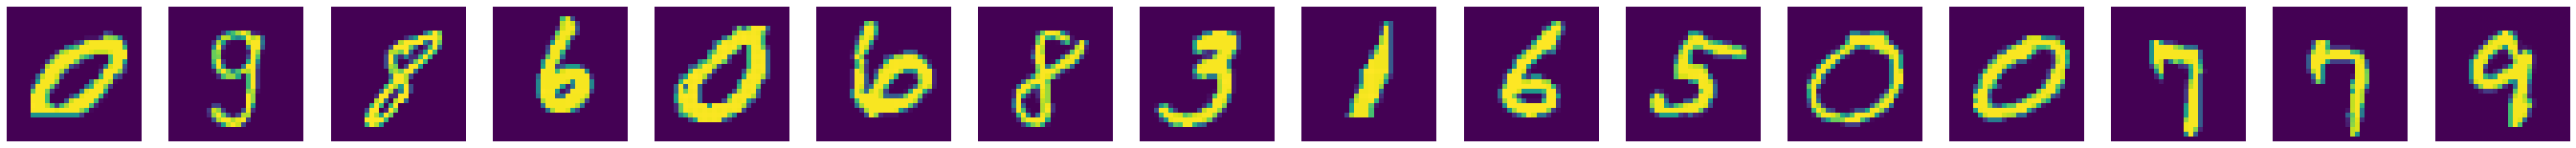

In [5]:
show_images(images)

In [6]:
flattener = nn.Flatten()

In [7]:
flattener(images).shape

torch.Size([16, 784])

In [8]:
linear_1 = nn.Linear(in_features=784, out_features=16, bias=False)
linear_2 = nn.Linear(in_features=16, out_features=10, bias=False)
# nn.Sequential just connects the output of one function into the input of the next.
# In this case we'll use it to connect the flattener to the linear layer.
model = nn.Sequential(
    flattener,
    linear_1,
    nn.ReLU(),
    linear_2
)

In [9]:
model.to(images.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=16, bias=False)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=10, bias=False)
)

In [10]:
logits = model(images) # if this fails, check the input dimensionality of the model.
print("Logits shape:", logits.shape)
assert logits.shape == (16, 10) # if this fails, check the output dimensionality of the model.

Logits shape: torch.Size([16, 10])


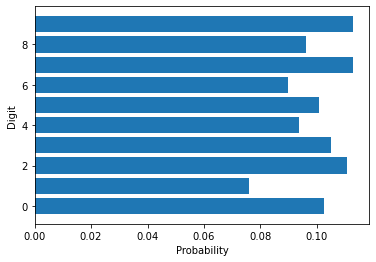

In [11]:
probs = logits.softmax(dim=-1)
plt.barh(torch.arange(10), probs[0].detach().cpu()); plt.xlabel("Probability"); plt.ylabel("Digit");
# side note: the `detach` is needed because we don't need to take the gradient of this *plot*.

In [12]:
loss = F.cross_entropy(logits, labels, reduction='none')
loss

tensor([2.2784, 2.2861, 2.1973, 2.3264, 2.2808, 2.2120, 2.2704, 2.2756, 2.4060,
        2.2738, 2.2947, 2.3240, 2.3166, 2.2930, 2.3002, 2.2423],
       device='cuda:0', grad_fn=<NllLossBackward0>)

In [13]:
loss.mean()

tensor(2.2861, device='cuda:0', grad_fn=<MeanBackward0>)

In [14]:
predictions = logits.argmax(dim=1) # note: we could also use `probs`. Why?
print(predictions.shape)
predictions

torch.Size([16])


tensor([9, 8, 9, 3, 2, 6, 9, 7, 3, 9, 8, 2, 3, 6, 2, 8], device='cuda:0')

In [ ]:
del images, labels, logits, loss, probs, predictions

Epoch  0: loss=0.85, train accuracy 3748/4992
Epoch  1: loss=0.62, train accuracy 4410/4992
Epoch  2: loss=0.52, train accuracy 4520/4992
Epoch  3: loss=0.46, train accuracy 4600/4992
Epoch  4: loss=0.42, train accuracy 4625/4992
Epoch  5: loss=0.38, train accuracy 4699/4992
Epoch  6: loss=0.36, train accuracy 4691/4992
Epoch  7: loss=0.33, train accuracy 4744/4992
Epoch  8: loss=0.31, train accuracy 4775/4992
Epoch  9: loss=0.30, train accuracy 4772/4992


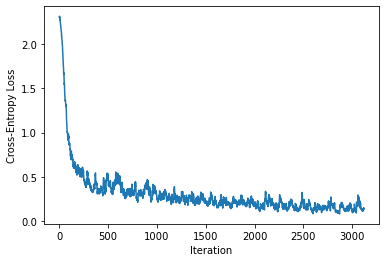

In [16]:
num_epochs = 10 # increase this to 10 or 20 once your training loop is working
learning_rate = .1
losses = []

# Re-initialize the parameters of the model, so training restarts when this block starts.
linear_1.reset_parameters()
linear_2.reset_parameters()

for epoch in range(num_epochs):
    # Keep track of some things for each epoch.
    total_images = 0
    total_correct = 0

    # Loop over the training data in batches.
    for images, labels in dataloaders.train:
        images = cast(images, Tensor) # work around a quirk in fastai, ignore this
        labels = cast(labels, Tensor)
        
        logits = model(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()

        # take an SGD step.
        loss.backward()
        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
        model.zero_grad()

        # Track metrics
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate

        # Track losses.
        # The .item method converts a 1-element tensor to a Python number.
        losses.append(loss.item())

    # Epoch done, print some stats.
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")

# Plot the un-smoothed loss
#plt.plot(losses)
# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");